## 每月期望值統計資料

In [28]:
import pandas as pd
import numpy as np

sheetName = 'all' # 交易資料 by 年份

dates=['2018-12','2018-11','2018-10','2018-9','2018-8','2018-7',\
       '2018-6','2018-5','2018-4','2018-3','2018-2','2018-1',\
       '2017-12','2017-11','2017-10']

df = pd.read_excel('files/data.xlsx', sheetname=sheetName)

df['Date'] = df['成交時間'].dt.year.astype(str)+'-'+df['成交時間'].dt.month.astype(str)
df['Lot'] = df['口數']
df['Balance'] = df['平倉損益']

df = df[['Date','Lot','Balance']]

datas = []
for date in reversed(dates):
    df1 = df[df['Date']==date]
    if not df1.empty:
        obj = {}
        obj['年月份'] = date
        obj['虧損口數'] = df1[df1['Balance']<0]['Lot'].sum()
        obj['獲利口數'] = df1[df1['Balance']>=0]['Lot'].sum()
        obj['總口數'] = df1['Lot'].sum()
        obj['勝率%'] = str(round((obj['獲利口數'] / obj['總口數'])*100, 1))+'%'
        obj['總虧損'] = df1[df1['Balance']<0]['Balance'].sum()
        obj['總獲利'] = df1[df1['Balance']>=0]['Balance'].sum()
        obj['淨利'] = df1['Balance'].sum()
        obj['期望值(E)'] = round((obj['淨利'] / obj['總口數']))
        obj['平均虧損'] = round(obj['總虧損'] / obj['虧損口數'],0)
        obj['平均獲利'] = round(obj['總獲利'] / obj['獲利口數'],0)
        obj['最大虧損'] = df1['Balance'].min()
        obj['最大獲利'] = df1['Balance'].max()
        datas.append(obj)

# Total        
obj ={}
obj['年月份'] = 'Total'
obj['虧損口數'] = df[df['Balance']<0]['Lot'].sum()
obj['獲利口數'] = df[df['Balance']>=0]['Lot'].sum()
obj['總口數'] = df['Lot'].sum()
obj['勝率%'] = str(round((obj['獲利口數'] / obj['總口數'])*100, 1))+'%'
obj['總虧損'] = df[df['Balance']<0]['Balance'].sum()
obj['總獲利'] = df[df['Balance']>=0]['Balance'].sum()
obj['淨利'] = df['Balance'].sum()
obj['期望值(E)'] = round((obj['淨利'] / obj['總口數']))
obj['平均虧損'] = round(obj['總虧損'] / obj['虧損口數'],0)
obj['平均獲利'] = round(obj['總獲利'] / obj['獲利口數'],0)
obj['最大虧損'] = df['Balance'].min()
obj['最大獲利'] = df['Balance'].max()
obj['交易品質'] = round((obj['平均獲利'] / obj['平均虧損'] * -1) - (obj['虧損口數'] / obj['獲利口數']),2)
datas.insert(0,obj)
       
df = pd.DataFrame(datas).sort_index(ascending=False)

print('交易聖經：接受最大逆境; 市場該做的事就是讓大多數的人失望！永遠不要覺得好像容易了...')

df[['年月份','虧損口數','獲利口數','總口數','勝率%','總虧損','總獲利','淨利','期望值(E)','平均虧損','平均獲利','最大虧損','最大獲利','交易品質']]

# 交易系統關鍵：正期望值 * 交易機會 * 部位大小(破產風險)
# 交易品質：大於1表示完美; 0.75~1表示不錯; 0.5~0.75表示可用稍不足; 小於0.5表示不能用

交易聖經：接受最大逆境; 市場該做的事就是讓大多數的人失望！永遠不要覺得好像容易了...


,年月份,虧損口數,獲利口數,總口數,勝率%,總虧損,總獲利,淨利,期望值(E),平均虧損,平均獲利,最大虧損,最大獲利,交易品質
6,2018-3,16,15,31,48.4%,-10166,21748,11582,374.0,-635.0,1450.0,-3108,11492,NaN
5,2018-2,22,20,42,47.6%,-33177,74996,41819,996.0,-1508.0,3750.0,-7314,17940,NaN
4,2018-1,11,13,24,54.2%,-8013,34684,26671,1111.0,-728.0,2668.0,-3264,11218,NaN
3,2017-12,9,11,20,55.0%,-14128,13961,-167,-8.0,-1570.0,1269.0,-4481,7019,NaN
2,2017-11,7,3,10,30.0%,-8674,7104,-1570,-157.0,-1239.0,2368.0,-3132,5968,NaN
1,2017-10,6,9,15,60.0%,-8090,17965,9875,658.0,-1348.0,1996.0,-2032,14069,NaN
0,Total,71,71,142,50.0%,-82248,170458,88210,621.0,-1158.0,2401.0,-7314,17940,1.07


## 部位規模控制 - 交易口數

In [31]:
# 固定百分率 - 專業交易員最常用
# 公式：合約口數 = (固定百分率 * 帳戶餘額) / 個別交易風險
# 個別交易風險: 近三個月最大虧損的平均
a = 0.2
b = obj['淨利']
c = abs((datas[-1]['最大虧損'] + datas[-2]['最大虧損'] + datas[-3]['最大虧損']) / 3)
positionSize = (b * a) / c

math.floor(a)
print('合約口數:',(b * a) / c)

合約口數: 3.86716352477


In [ ]:
math.floor(a)

## 破產風險 ＆ 期望報酬(R)
#### 破產風險 = 虧損機率 ** ( ( 淨利  x  0.2 ) / ( 平均虧損 x 部位規模 ) ) ---- 破產定義：淨利減少2成就算破產!!
#### 單筆虧損(%) 建議要低於 2%, 1.5%更佳; 長期甚至低於1%
#### 破產風險(%) 建議要降為 0%

In [26]:
positionSize = 4  # 部位規模 = 長線口數 + 短線口數
print('目前淨利    : '+str(obj['淨利']))
print('單筆虧損(%) : '+str(round(abs((obj['平均虧損'] * positionSize/2) / obj['淨利']),3) * 100)+'%')
print('平均虧損    : '+str(round(obj['總虧損'] / obj['虧損口數'],0)))
print('破產風險    : '+str(round((obj['虧損口數'] / obj['總口數']) ** abs((obj['淨利']*0.2) / (obj['平均虧損'] * (positionSize/2))) * 100, 2))+'%')
print('期望報酬(R) : '+str(round((obj['期望值(E)'] / obj['平均虧損']) * -1,2))+'R')
print('實現報酬(R) : '+str(round((obj['期望值(E)'] / obj['平均虧損']) * -1,2) * obj['總口數'] )+'R')
print('==========================================')
print('淨利七成    : '+str(round((obj['虧損口數'] / obj['總口數']) ** abs((obj['淨利']*0.3) / (obj['平均虧損'] * (positionSize/2))) * 100, 2))+'%')
print('淨利減半    : '+str(round((obj['虧損口數'] / obj['總口數']) ** abs((obj['淨利']*0.5) / (obj['平均虧損'] * (positionSize/2))) * 100, 2))+'%')

目前淨利    : 88210
單筆虧損(%) : 2.6%
平均虧損    : -1158.0
破產風險    : 0.51%
期望報酬(R) : 0.54R
實現報酬(R) : 76.68R
淨利七成    : 0.04%
淨利減半    : 0.0%


## 部位規模控制

In [24]:
# 固定百分率 - 專業交易員最常用
# 公式：合約口數 = (固定百分率 * 帳戶餘額) / 個別交易風險
# 個別交易風險: 近三個月最大虧損的平均
a = 0.2
b = obj['淨利']
c = abs((datas[-1]['最大虧損'] + datas[-2]['最大虧損'] + datas[-3]['最大虧損']) / 3)
print('合約口數:',(b * a) / c)


合約口數: 3.86716352477


## 每月交易統計紀錄

In [3]:
import pandas as pd
import numpy as np

dates=['2018-12','2018-11','2018-10','2018-9','2018-8','2018-7',\
       '2018-6','2018-5','2018-4','2018-3','2018-2','2018-1',\
        '2017-12','2017-11','2017-10']

df = pd.read_excel('files/data.xlsx', sheetname=sheetName)

df['Date'] = df['成交時間'].dt.year.astype(str)+'-'+df['成交時間'].dt.month.astype(str)
df['Lot'] = df['口數']
df['Balance'] = df['平倉損益']

df = df[['Date','Lot','Balance']]

datas = []
for date in reversed(dates):
    df1 = df[df['Date']==date]
    if not df1.empty:
        obj = {}
        obj['年月份'] = date
        obj['-90~60'] = df1[(df1['Balance']/df1['Lot'] >= -4500) & (df1['Balance']/df1['Lot'] < -3000)]['Lot'].sum()
        obj['-60~45'] = df1[(df1['Balance']/df1['Lot'] >= -3000) & (df1['Balance']/df1['Lot'] < -2250)]['Lot'].sum()
        obj['-45~30'] = df1[(df1['Balance']/df1['Lot'] >= -2250) & (df1['Balance']/df1['Lot'] < -1500)]['Lot'].sum()
        obj['-30~15'] = df1[(df1['Balance']/df1['Lot'] >= -1500) & (df1['Balance']/df1['Lot'] < -750)]['Lot'].sum()
        obj['-15~0'] = df1[(df1['Balance']/df1['Lot'] >= -750) & (df1['Balance']/df1['Lot'] < 0)]['Lot'].sum()
        obj['0~15'] = df1[(df1['Balance']/df1['Lot'] >= 0) & (df1['Balance']/df1['Lot'] < 750)]['Lot'].sum()
        obj['15~30'] = df1[(df1['Balance']/df1['Lot'] >= 750) & (df1['Balance']/df1['Lot'] < 1500)]['Lot'].sum()
        obj['30~45'] = df1[(df1['Balance']/df1['Lot'] >= 1500) & (df1['Balance']/df1['Lot'] < 2250)]['Lot'].sum()
        obj['45~60'] = df1[(df1['Balance']/df1['Lot'] >= 2250) & (df1['Balance']/df1['Lot'] < 3000)]['Lot'].sum()
        obj['60~90'] = df1[(df1['Balance']/df1['Lot'] >= 3000) & (df1['Balance']/df1['Lot'] < 4500)]['Lot'].sum()
        obj['90~120'] = df1[(df1['Balance']/df1['Lot'] >= 4500) & (df1['Balance']/df1['Lot'] < 6000)]['Lot'].sum()
        obj['120~150'] = df1[(df1['Balance']/df1['Lot'] >= 6000) & (df1['Balance']/df1['Lot'] < 7500)]['Lot'].sum()
        obj['150~180'] = df1[(df1['Balance']/df1['Lot'] >= 7500) & (df1['Balance']/df1['Lot'] < 9000)]['Lot'].sum()
        obj['180~210'] = df1[(df1['Balance']/df1['Lot'] >= 9000) & (df1['Balance']/df1['Lot'] < 10500)]['Lot'].sum()
        obj['210~240'] = df1[(df1['Balance']/df1['Lot'] >= 10500) & (df1['Balance']/df1['Lot'] < 12000)]['Lot'].sum()
        obj['240~270'] = df1[(df1['Balance']/df1['Lot'] >= 12000) & (df1['Balance']/df1['Lot'] < 13500)]['Lot'].sum()
        obj['270~500'] = df1[(df1['Balance']/df1['Lot'] >= 13500) & (df1['Balance']/df1['Lot'] < 25000)]['Lot'].sum()
        datas.append(obj)

# Lot Sum
obj = {}
obj['年月份'] = 'Total'
obj['-90~60'] = df[(df['Balance']/df['Lot'] >= -4500) & (df['Balance']/df['Lot'] < -3000)]['Lot'].sum()
obj['-60~45'] = df[(df['Balance']/df['Lot'] >= -3000) & (df['Balance']/df['Lot'] < -2250)]['Lot'].sum()
obj['-45~30'] = df[(df['Balance']/df['Lot'] >= -2250) & (df['Balance']/df['Lot'] < -1500)]['Lot'].sum()
obj['-30~15'] = df[(df['Balance']/df['Lot'] >= -1500) & (df['Balance']/df['Lot'] < -750)]['Lot'].sum()
obj['-15~0'] = df[(df['Balance']/df['Lot'] >= -750) & (df['Balance']/df['Lot'] < 0)]['Lot'].sum()
obj['0~15'] = df[(df['Balance']/df['Lot'] >= 0) & (df['Balance']/df['Lot'] < 750)]['Lot'].sum()
obj['15~30'] = df[(df['Balance']/df['Lot'] >= 750) & (df['Balance']/df['Lot'] < 1500)]['Lot'].sum()
obj['30~45'] = df[(df['Balance']/df['Lot'] >= 1500) & (df['Balance']/df['Lot'] < 2250)]['Lot'].sum()
obj['45~60'] = df[(df['Balance']/df['Lot'] >= 2250) & (df['Balance']/df['Lot'] < 3000)]['Lot'].sum()
obj['60~90'] = df[(df['Balance']/df['Lot'] >= 3000) & (df['Balance']/df['Lot'] < 4500)]['Lot'].sum()
obj['90~120'] = df[(df['Balance']/df['Lot'] >= 4500) & (df['Balance']/df['Lot'] < 6000)]['Lot'].sum()
obj['120~150'] = df[(df['Balance']/df['Lot'] >= 6000) & (df['Balance']/df['Lot'] < 7500)]['Lot'].sum()
obj['150~180'] = df[(df['Balance']/df['Lot'] >= 7500) & (df['Balance']/df['Lot'] < 9000)]['Lot'].sum()
obj['180~210'] = df[(df['Balance']/df['Lot'] >= 9000) & (df['Balance']/df['Lot'] < 10500)]['Lot'].sum()
obj['210~240'] = df[(df['Balance']/df['Lot'] >= 10500) & (df['Balance']/df['Lot'] < 12000)]['Lot'].sum()
obj['240~270'] = df[(df['Balance']/df['Lot'] >= 12000) & (df['Balance']/df['Lot'] < 13500)]['Lot'].sum()
obj['270~500'] = df[(df['Balance']/df['Lot'] >= 13500) & (df['Balance']/df['Lot'] < 25000)]['Lot'].sum()
datas.insert(0,obj)

# Balance Sum
obj = {}
obj['年月份'] = '損益金額'
obj['-90~60'] = df[(df['Balance']/df['Lot'] >= -4500) & (df['Balance']/df['Lot'] < -3000)]['Balance'].sum()
obj['-60~45'] = df[(df['Balance']/df['Lot'] >= -3000) & (df['Balance']/df['Lot'] < -2250)]['Balance'].sum()
obj['-45~30'] = df[(df['Balance']/df['Lot'] >= -2250) & (df['Balance']/df['Lot'] < -1500)]['Balance'].sum()
obj['-30~15'] = df[(df['Balance']/df['Lot'] >= -1500) & (df['Balance']/df['Lot'] < -750)]['Balance'].sum()
obj['-15~0'] = df[(df['Balance']/df['Lot'] >= -750) & (df['Balance']/df['Lot'] < 0)]['Balance'].sum()
obj['0~15'] = df[(df['Balance']/df['Lot'] >= 0) & (df['Balance']/df['Lot'] < 750)]['Balance'].sum()
obj['15~30'] = df[(df['Balance']/df['Lot'] >= 750) & (df['Balance']/df['Lot'] < 1500)]['Balance'].sum()
obj['30~45'] = df[(df['Balance']/df['Lot'] >= 1500) & (df['Balance']/df['Lot'] < 2250)]['Balance'].sum()
obj['45~60'] = df[(df['Balance']/df['Lot'] >= 2250) & (df['Balance']/df['Lot'] < 3000)]['Balance'].sum()
obj['60~90'] = df[(df['Balance']/df['Lot'] >= 3000) & (df['Balance']/df['Lot'] < 4500)]['Balance'].sum()
obj['90~120'] = df[(df['Balance']/df['Lot'] >= 4500) & (df['Balance']/df['Lot'] < 6000)]['Balance'].sum()
obj['120~150'] = df[(df['Balance']/df['Lot'] >= 6000) & (df['Balance']/df['Lot'] < 7500)]['Balance'].sum()
obj['150~180'] = df[(df['Balance']/df['Lot'] >= 7500) & (df['Balance']/df['Lot'] < 9000)]['Balance'].sum()
obj['180~210'] = df[(df['Balance']/df['Lot'] >= 9000) & (df['Balance']/df['Lot'] < 10500)]['Balance'].sum()
obj['210~240'] = df[(df['Balance']/df['Lot'] >= 10500) & (df['Balance']/df['Lot'] < 12000)]['Balance'].sum()
obj['240~270'] = df[(df['Balance']/df['Lot'] >= 12000) & (df['Balance']/df['Lot'] < 13500)]['Balance'].sum()
obj['270~500'] = df[(df['Balance']/df['Lot'] >= 13500) & (df['Balance']/df['Lot'] < 25000)]['Balance'].sum()
datas.insert(0,obj)

        
df = pd.DataFrame(datas).sort_index(ascending=False)
df = df[['年月份','-90~60','-60~45','-45~30','-30~15','-15~0','0~15','15~30','30~45','45~60','60~90', \
         '90~120','120~150','150~180','180~210','210~240','240~270','270~500']]

df

,年月份,-90~60,-60~45,-45~30,-30~15,-15~0,0~15,15~30,30~45,45~60,60~90,90~120,120~150,150~180,180~210,210~240,240~270,270~500
7,2018-3,0,0,2,3,11,9,0,2,2,0,2,0,0,0,0,0,0
6,2018-2,4,0,4,9,5,7,2,1,2,0,2,1,4,1,0,0,0
5,2018-1,0,0,2,2,7,6,2,0,1,2,0,0,0,1,1,0,0
4,2017-12,1,0,3,2,3,9,0,0,0,1,0,1,0,0,0,0,0
3,2017-11,1,0,2,0,4,2,0,0,0,0,1,0,0,0,0,0,0
2,2017-10,0,0,4,0,2,5,3,0,0,0,0,0,0,0,0,0,1
1,Total,6,0,17,16,32,38,7,3,5,3,5,2,4,2,1,0,1
0,損益金額,-22491,0,-30202,-16380,-13175,9684,7238,5940,12396,11006,28746,14117,35880,20164,11218,0,14069


## 交易紀錄統計長條圖

Populating the interactive namespace from numpy and matplotlib


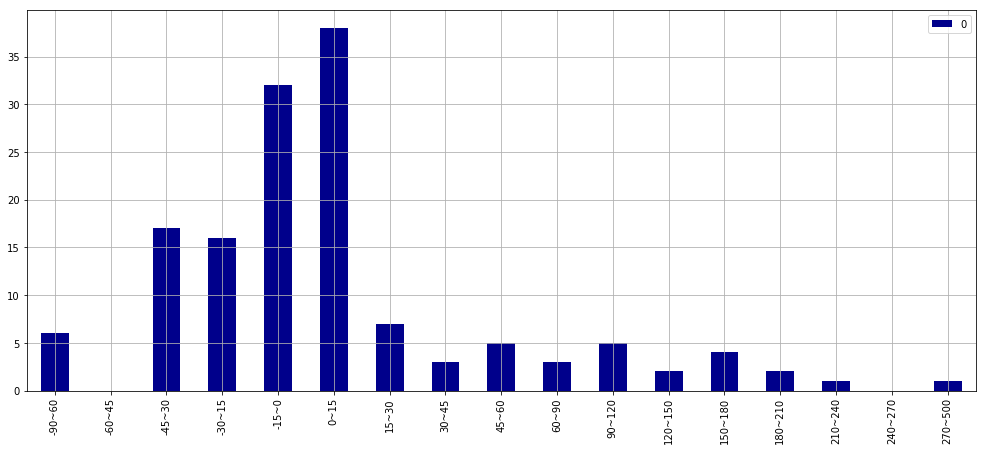

In [4]:
%pylab inline

import pandas as pd
import numpy as np

df = pd.read_excel('files/data.xlsx', sheetname=sheetName)

df['Date'] = df['成交時間'].dt.year.astype(str)+df['成交時間'].dt.month.astype(str)
df['Lot'] = df['口數']
df['Balance'] = df['平倉損益']

df = df[['Date','Lot','Balance']]

obj = {}
obj['-90~60'] = df[(df['Balance']/df['Lot'] >= -4500) & (df['Balance']/df['Lot'] < -3000)]['Lot'].sum()
obj['-60~45'] = df[(df['Balance']/df['Lot'] >= -3000) & (df['Balance']/df['Lot'] < -2250)]['Lot'].sum()
obj['-45~30'] = df[(df['Balance']/df['Lot'] >= -2250) & (df['Balance']/df['Lot'] < -1500)]['Lot'].sum()
obj['-30~15'] = df[(df['Balance']/df['Lot'] >= -1500) & (df['Balance']/df['Lot'] < -750)]['Lot'].sum()
obj['-15~0'] = df[(df['Balance']/df['Lot'] >= -750) & (df['Balance']/df['Lot'] < 0)]['Lot'].sum()
obj['0~15'] = df[(df['Balance']/df['Lot'] >= 0) & (df['Balance']/df['Lot'] < 750)]['Lot'].sum()
obj['15~30'] = df[(df['Balance']/df['Lot'] >= 750) & (df['Balance']/df['Lot'] < 1500)]['Lot'].sum()
obj['30~45'] = df[(df['Balance']/df['Lot'] >= 1500) & (df['Balance']/df['Lot'] < 2250)]['Lot'].sum()
obj['45~60'] = df[(df['Balance']/df['Lot'] >= 2250) & (df['Balance']/df['Lot'] < 3000)]['Lot'].sum()
obj['60~90'] = df[(df['Balance']/df['Lot'] >= 3000) & (df['Balance']/df['Lot'] < 4500)]['Lot'].sum()
obj['90~120'] = df[(df['Balance']/df['Lot'] >= 4500) & (df['Balance']/df['Lot'] < 6000)]['Lot'].sum()
obj['120~150'] = df[(df['Balance']/df['Lot'] >= 6000) & (df['Balance']/df['Lot'] < 7500)]['Lot'].sum()
obj['150~180'] = df[(df['Balance']/df['Lot'] >= 7500) & (df['Balance']/df['Lot'] < 9000)]['Lot'].sum()
obj['180~210'] = df[(df['Balance']/df['Lot'] >= 9000) & (df['Balance']/df['Lot'] < 10500)]['Lot'].sum()
obj['210~240'] = df[(df['Balance']/df['Lot'] >= 10500) & (df['Balance']/df['Lot'] < 12000)]['Lot'].sum()
obj['240~270'] = df[(df['Balance']/df['Lot'] >= 12000) & (df['Balance']/df['Lot'] < 13500)]['Lot'].sum()
obj['270~500'] = df[(df['Balance']/df['Lot'] >= 13500) & (df['Balance']/df['Lot'] < 25000)]['Lot'].sum()

df = pd.DataFrame(obj, index=[0])
df = df[['-90~60','-60~45','-45~30','-30~15','-15~0','0~15','15~30','30~45','45~60', \
         '60~90','90~120','120~150','150~180','180~210','210~240','240~270','270~500']]

df = pd.DataFrame(df.stack()[0])
df.plot(kind='bar',figsize=(17,7),color='DarkBlue',grid=True) # DarkGreen, DarkOrange, DarkBlue, Gray



## 平倉損益淨利累積曲線圖

Populating the interactive namespace from numpy and matplotlib


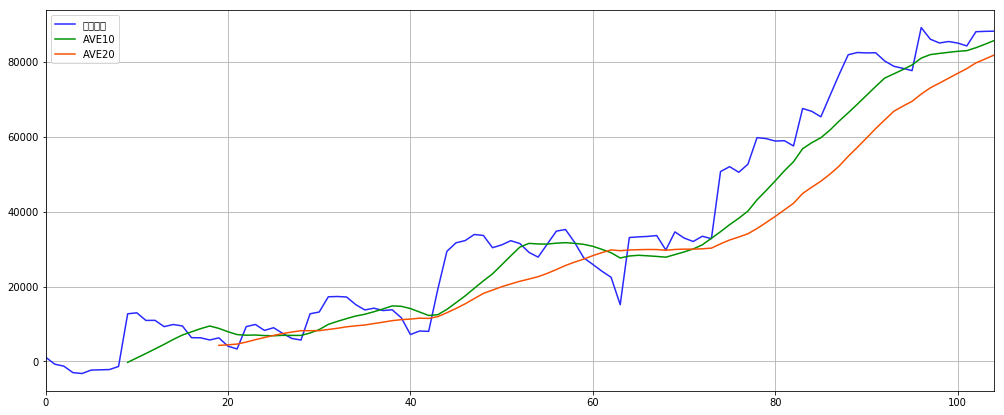

In [5]:
%pylab inline

import pandas as pd
import numpy as np

df = pd.read_excel('files/data.xlsx', sheetname=sheetName)
df = pd.DataFrame(df['平倉損益'].cumsum())

df['AVE10'] =  df['平倉損益'].rolling(window = 10).mean()
df['AVE20'] =  df['平倉損益'].rolling(window = 20).mean()
df
df.plot(kind='line',figsize=(17,7),color=['#2828FF','#009100','#F75000'],grid=True) 

# End!!